# Demo: Calibration Directly using Simulator (no emulator in MCMC)

- Author: Arthur Lui
- Email: alui@lanl.gov
- Date: 18 Feb, 2022

WIP

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sepia
from sepia import SepiaData, SepiaModel
from sepia.contrib import emufree_calib_model
from scipy.linalg import block_diag
from sepia.contrib.ppl import distributions as dist
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Simulator gridsize.
sim_gridsize = 60

# Simulator grid.
sim_grid = np.linspace(0, 1, sim_gridsize)

# Simulator.
def eta(x, t):
    return t[0] + 0.25 * np.sin(sim_grid * 4 * np.pi) * x[0]
# Discrepancy.
def delta(x, a=3):
    return np.clip(sim_grid - np.power(x[0], 0.2), 0, np.inf) * np.sqrt(x[0] * a)

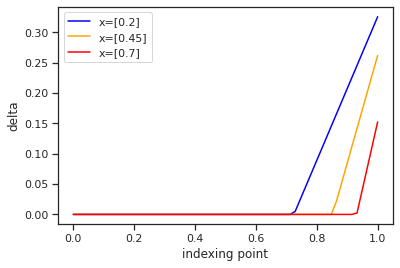

In [4]:
# Generate data.
np.random.seed(0)

num_obs = 3
xs = np.linspace(.2, .7, num_obs)[:, None]
theta = np.array([.7])
lam_true = 0.01
a = 7

colors = ["blue", "orange", "red"]
true_discrepancy = [delta(x, a=a) for x in xs]
ys = [np.random.normal(eta(x, theta) + delta(x, a=a), lam_true) for x in xs]  # TODO: wrong?
y = np.concatenate(ys)

for i, x in enumerate(xs):
    plt.plot(sim_grid, true_discrepancy[i], label=f"x={x}", color=colors[i])
plt.legend()
plt.xlabel("indexing point")
plt.ylabel("delta")
plt.show()

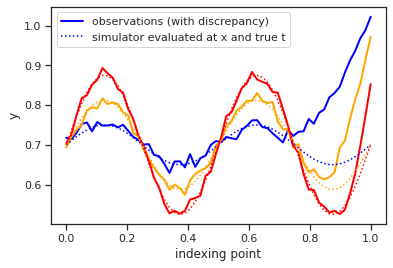

In [5]:
for i, x in enumerate(xs):
    # plt.plot(sim_grid, ys[i], lw=3)
    label = None if i > 0 else "observations (with discrepancy)"
    plt.plot(sim_grid, ys[i], label=label, lw=2, color=colors[i])
for i, x in enumerate(xs):
    label = None if i > 0 else "simulator evaluated at x and true t"
    plt.plot(sim_grid, eta(x, theta), label=label, ls=":", color=colors[i])
plt.xlabel("indexing point")
plt.ylabel("y")
plt.legend()
plt.show()

In [6]:
# Base sepia data.
# TODO: sim_grid should be in SepiaData, I think y_obs_ind?
sepia_data = SepiaData(x_obs=xs, y_obs=ys, theta_dim=1, eta=eta, Sigy=np.eye(y.shape[0]))

# Create D basis.
# TODO: Allow user to specify some basic bases (e.g. Gaussian kernels, linear, constant, hinge).
num_basis = 21
knots = np.linspace(0, 1, num_basis)
def make_D(knots, num_obs):
    num_basis = knots.shape[0]
    return block_diag(*[
        dist.Normal(knots[None, :], 1/(num_basis-1)).pdf(sim_grid[:, None])
        for _ in range(num_obs)
    ])
D = make_D(knots, num_obs)

sepia_data.create_D_basis(D_obs=D, num_basis=num_basis)

In [7]:
sepia_model = SepiaModel(sepia_data)

In [8]:
result = sepia_model.do_mcmc(1000, burn=3000, thinning=3)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:50<00:00, 118.44it/s]


In [9]:
print("result.keys(): ", result.keys())
samples = result['samples']

print("samples.keys(): ", samples.keys())

result.keys():  dict_keys(['mcmc', 'samples', 'init_state', 'kernel', 'window', 'burn', 'num_samples', 'thinning'])
samples.keys():  dict_keys(['length_scale', 'process_sd', 't', 'lam'])


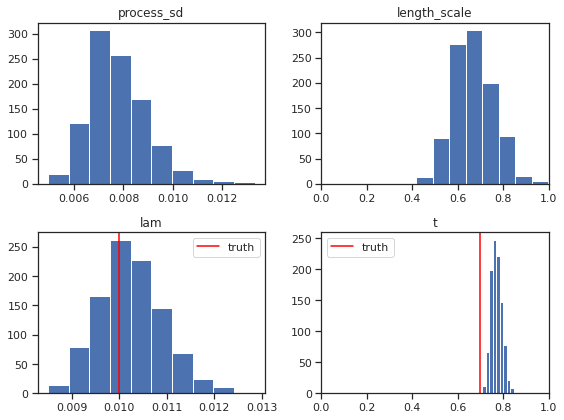

In [10]:
plt.figure(figsize=(8, 6))

plt.subplot(2, 2, 1)
plt.hist(samples["process_sd"])
plt.title("process_sd")

plt.subplot(2, 2, 2)
plt.hist(samples['length_scale'])
plt.title("length_scale")
plt.xlim(0, 1)

plt.subplot(2, 2, 3)
plt.hist(samples['lam'])
plt.title("lam")
plt.axvline(lam_true, color="red", label="truth")
plt.legend()

plt.subplot(2, 2, 4)
plt.hist(samples["t"].flatten())
plt.title("t")
plt.xlim(0, 1)
plt.axvline(theta, color="red", label="truth")
plt.legend()

plt.tight_layout()
plt.show()

***

## TODO

18 Feb, 2022.
- [ ] Allow user to specify `sim_grid` in `SepiaData`
- [ ] Allow user to specify a bases form for `D` (e.g. hinges, constant, linear, Gaussian kernel)
- [ ] posterior predictive method, optionally at new locations (`xs`).
- [ ] posterior distribution of discrepancy (`delta`), optionally at new locations (`xs`).